# 2. Exploratory Data Analysis

In [1]:
#Import the necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#Load the data
df = pd.read_csv('Corona_NLP.csv')

Because this is a categorization problem, there isn't much EDA to be done until I tokenize and vectorize all of 
the words in the OriginalTweet column during the pre-processing stage of analysis. For now, I've simply produced a 
value count of the different sentiment scores, plotted it as a histogram, and assessed how well my own impression 
of the data coheres with the sentiment scores assigned by the dataset's creator using a hypothesis test.

In [3]:
df['Sentiment'].value_counts()

Positive              12366
Negative              10951
Neutral                8313
Extremely Positive     7223
Extremely Negative     6071
Name: Sentiment, dtype: int64

Interestingly, the value count skews toward the positive with more positive tweets than negative ones and 
more extremely positive tweets than extremely negative ones. Neutral tweets are also less common than positive and
negative tweets, yielding a distribution with two peaks. 

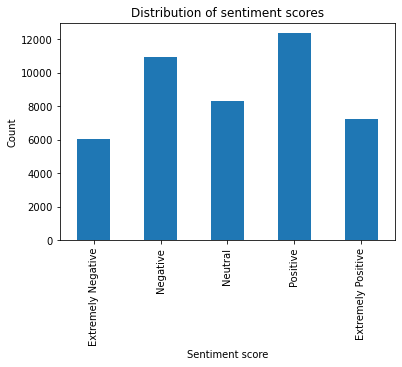

In [4]:
df['Sentiment'].value_counts().loc[['Extremely Negative', 'Negative', 'Neutral', 'Positive', 'Extremely Positive']].plot.bar()
plt.xlabel('Sentiment score')
plt.ylabel('Count')
plt.title('Distribution of sentiment scores')
plt.show();

Assessment of sentiment depends on a variety of factors (e.g., cultural context, individual disposition, etc.). 
Therefore, it is important to determine whether and to what extent I agree with the sentiment scores that 
the dataset's creator assigned to each Tweet. To do so, I examined a pseudo-random sample of ten Tweets and added 
my own sentiment scores to the sample data.  

In [5]:
pd.set_option('display.max_colwidth', 500)
sample = df.sample(10, random_state=42) #set the random state to ensure reproducibility
sample['OriginalTweet']
sample["Aren's Sentiment"] = ['Neutral', 'Neutral', 'Neutral', 'Negative', 'Positive', 'Negative', 'Extremely Negative', 'Positive', 'Neutral', 'Neutral']

I then checked them against the scores assigned by the dataset's creator. 

In [6]:
sample

,Unnamed: 0,OriginalTweet,Sentiment,Aren's Sentiment
37162,37186,New research from and shows a consumer spending spike due to stockpiling amid the COVID 19 pandemic Frozen pizza purchases are up 117 and frozen cookie dough sales have risen 570,Neutral,Neutral
21958,21975,"The #coronavirus social distancing &amp; stay home measures creating opportunities for eCommerce platforms around the world including Gobeba of #Kenya seeing a tripling of orders, especially in food &amp; household items as more Kenyans shift to online shopping! @alnafrica news.",Positive,Neutral
41967,41994,@Flipkart @TataConsumer announce partnership to enable access to essential food amp beverage products to consumers as Collaboration is key to success to ensure @PMOIndia @amitabhk87,Extremely Positive,Neutral
31033,31054,"Id like to use this time to be super productive during this pandemic, but all I have so far is an online shopping debt and a full fledged alcohol problem #Lockdownaustralia #coronavirus #Isolation",Negative,Negative
30260,30278,Don t be intimidated by the Covid 19 Virus Stay clean and avoid public meetings And pray to the Creator for all A good atmosphere is needed to get the pure air Welcome to Online Shopping Please visit,Extremely Positive,Positive
18378,18390,#covid-19 #corona please don't over react and buy face masks and sanitizers heavily which helps in scarcity of those and hike in prices ....don't make them scarce for needed. https://t.co/VSJAHA9puU,Positive,Negative
38978,39002,"I work at a grocery store. a relatively young customer just told me #coronavirus is ""a Chinese attack in retaliation for the tariffs we put on them"". what the fuck is wrong with America and American media",Extremely Negative,Extremely Negative
20152,20168,Dont forget to donate some food to your local food bank when you visit the supermarket. There are people out there who desperately need our help. I fear that they may have been forgotten about with all this #PanicBuying mayhem going on. #FoodBanks #coronavirus,Extremely Negative,Positive
38439,38463,"Mintel is measuring changes in the way consumers eat, travel, congregate and relate to the world around them during the #COVID19 pandemic. We're also uncovering the opportunities as business shifts to meet US consumer's needs. Learn more: https://t.co/cBsiCjyRUd #marketresearch",Positive,Neutral
31066,31087,Gain insights from the recent Brick Meets Click/ShopperKit online shopper survey plus leverage guidance &amp; perspectives that will help shape strategic decisions going forward. Register for this webinar: https://t.co/3pKIpmG7xc #onlinegrocery https://t.co/3ITUYQ0qaS,Extremely Positive,Neutral


As the resulting DataFrame shows, our sentiment scores differ in several places. But how serious are these 
differences? To assess this, I replaced the categories with numbers and calculated the differences in our scores.

In [7]:
replacement_values = {"Extremely Negative": 0, "Negative" : 1, "Neutral" : 2, "Positive" : 3, "Extremely Positive" : 4}
sample["Sentiment"].replace(replacement_values, inplace=True)
sample["Aren's Sentiment"].replace(replacement_values, inplace=True)
sample["Difference"] = np.abs(sample["Sentiment"] - sample["Aren's Sentiment"])
sample

,Unnamed: 0,OriginalTweet,Sentiment,Aren's Sentiment,Difference
37162,37186,New research from and shows a consumer spending spike due to stockpiling amid the COVID 19 pandemic Frozen pizza purchases are up 117 and frozen cookie dough sales have risen 570,2,2,0
21958,21975,"The #coronavirus social distancing &amp; stay home measures creating opportunities for eCommerce platforms around the world including Gobeba of #Kenya seeing a tripling of orders, especially in food &amp; household items as more Kenyans shift to online shopping! @alnafrica news.",3,2,1
41967,41994,@Flipkart @TataConsumer announce partnership to enable access to essential food amp beverage products to consumers as Collaboration is key to success to ensure @PMOIndia @amitabhk87,4,2,2
31033,31054,"Id like to use this time to be super productive during this pandemic, but all I have so far is an online shopping debt and a full fledged alcohol problem #Lockdownaustralia #coronavirus #Isolation",1,1,0
30260,30278,Don t be intimidated by the Covid 19 Virus Stay clean and avoid public meetings And pray to the Creator for all A good atmosphere is needed to get the pure air Welcome to Online Shopping Please visit,4,3,1
18378,18390,#covid-19 #corona please don't over react and buy face masks and sanitizers heavily which helps in scarcity of those and hike in prices ....don't make them scarce for needed. https://t.co/VSJAHA9puU,3,1,2
38978,39002,"I work at a grocery store. a relatively young customer just told me #coronavirus is ""a Chinese attack in retaliation for the tariffs we put on them"". what the fuck is wrong with America and American media",0,0,0
20152,20168,Dont forget to donate some food to your local food bank when you visit the supermarket. There are people out there who desperately need our help. I fear that they may have been forgotten about with all this #PanicBuying mayhem going on. #FoodBanks #coronavirus,0,3,3
38439,38463,"Mintel is measuring changes in the way consumers eat, travel, congregate and relate to the world around them during the #COVID19 pandemic. We're also uncovering the opportunities as business shifts to meet US consumer's needs. Learn more: https://t.co/cBsiCjyRUd #marketresearch",3,2,1
31066,31087,Gain insights from the recent Brick Meets Click/ShopperKit online shopper survey plus leverage guidance &amp; perspectives that will help shape strategic decisions going forward. Register for this webinar: https://t.co/3pKIpmG7xc #onlinegrocery https://t.co/3ITUYQ0qaS,4,2,2


Overall there is a mean difference of 1.2 between our scores.

In [8]:
np.mean(sample['Difference'])

1.2

But with such a small sample size, the mean difference is more sensitive to outliers. If, for example, the dataset's creator and I strongly disagree about a small number of cases (like 20152) and one or more of these outliers are present in the sample, then the mean difference would be artificially inflated. To test whether or not this is the case, I've checked how the average mean difference changes as the number of samples increases. 

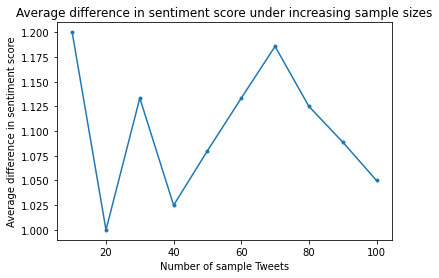

In [9]:
sample_sizes = np.arange(10, 110, 10)

variable_sample = df.sample(100, random_state=42)
variable_sample["Aren's Sentiment"] = ['Neutral', 'Neutral', 'Neutral', 'Negative', 'Positive', 'Negative', 'Extremely Negative', 'Positive', 'Neutral', 'Neutral', 'Extremely Negative', 'Negative', 'Extremely Negative', 'Neutral', 'Extremely Positive', 'Negative', 'Negative', 'Negative', 'Negative', 'Neutral', 'Extremely Negative', 'Positive', 'Negative', 'Negative', 'Extremely Negative', 'Neutral', 'Extremely Negative', 'Negative', 'Positive', 'Extremely Negative', 'Negative', 'Positive', 'Neutral', 'Negative', 'Negative', 'Positive', 'Extremely Negative', 'Extremely Negative', 'Negative', 'Negative', 'Negative', 'Neutral', 'Positive', 'Extremely Negative', 'Extremely Negative', 'Neutral', 'Negative', 'Extremely Negative', 'Negative', 'Neutral', 'Neutral', 'Negative', 'Positive', 'Negative', 'Neutral', 'Extremely Negative', 'Extremely Positive', 'Negative', 'Neutral', 'Neutral', 'Extremely Negative', 'Extremely Negative', 'Negative', 'Positive', 'Extremely Negative', 'Negative', 'Neutral', 'Neutral', 'Positive', 'Positive', 'Extremely Positive', 'Negative', 'Neutral', 'Extremely Negative', 'Neutral', 'Extremely Negative', 'Negative', 'Neutral', 'Negative', 'Positive', 'Neutral', 'Neutral', 'Neutral', 'Positive', 'Positive', 'Negative', 'Neutral', 'Negative', 'Negative', 'Positive', 'Neutral', 'Extremely Negative', 'Extremely Negative', 'Positive', 'Neutral', 'Neutral', 'Positive', 'Neutral', 'Extremely Positive', 'Positive']                                   
variable_sample["Sentiment"].replace(replacement_values, inplace=True)
variable_sample["Aren's Sentiment"].replace(replacement_values, inplace=True)
variable_sample["Difference"] = np.abs(variable_sample["Sentiment"] - variable_sample["Aren's Sentiment"])  

mean_diffs = [np.mean(variable_sample.iloc[:size]['Difference']) for size in sample_sizes]

plt.plot(sample_sizes, mean_diffs, marker='.')
plt.xlabel('Number of sample Tweets')
plt.ylabel('Average difference in sentiment score')
plt.title('Average difference in sentiment score under increasing sample sizes')
plt.show();

As the chart shows, the mean difference varies back and forth between 1.2 and 1 as the sample size increases, but appears to be converging somewhere 1.075. But what exactly does this mean? Does it indicate compatibility or incompatibility?  

We can answer this question by preforming a hypothesis test using 10000 bootstrap resamples of both the 10 tweet and 100 tweet samples. The null hypothesis is that our sentiment scores are fundamentally incompatible (i.e., have a mean difference of 2 or more, which corresponds to a change from negative to positive or vice-versa); the alternative hypothesis is that they are compatible.  

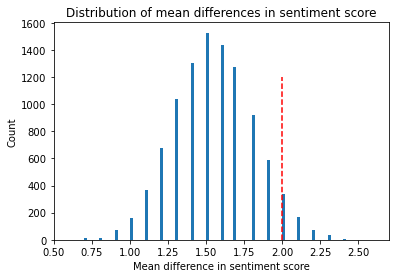

In [10]:
avg_diffs_10 = np.empty(10000)
np.random.seed(42) #set the seed to ensure reproducibility

for i in range(10000):
    avg_diffs_10[i] = np.mean(np.abs(sample["Sentiment"] - np.random.choice(sample["Aren's Sentiment"], 10)))

fig, ax = plt.subplots()
ax.hist(avg_diffs_10, bins=100)
ax.vlines(2, ymin=0, ymax=1200, color='red', linestyle='--')
ax.set_xlabel('Mean difference in sentiment score')
ax.set_ylabel('Count')
ax.set_title('Distribution of mean differences in sentiment score')
plt.show();

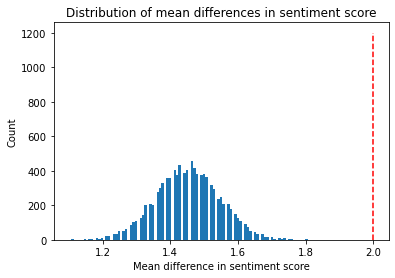

In [11]:
avg_diffs_100 = np.empty(10000)
np.random.seed(42) #set the seed to ensure reproducibility

for i in range(10000):
    avg_diffs_100[i] = np.mean(np.abs(variable_sample["Sentiment"] - np.random.choice(variable_sample["Aren's Sentiment"], 100)))

fig, ax = plt.subplots()
ax.hist(avg_diffs_100, bins=100)
ax.vlines(2, ymin=0, ymax=1200, color='red', linestyle='--')
ax.set_xlabel('Mean difference in sentiment score')
ax.set_ylabel('Count')
ax.set_title('Distribution of mean differences in sentiment score')
plt.show();

The p value for a mean of 2.0 is low (~.03) for the 10 Tweet sample (indicating that we would expect a mean difference in sentiment score of 2.0 or higher in only 3% of simulations due to natural variability alone.) and extremely low (less than .0001) for the 100 Tweet sample. So I feel fairly confident in rejecting the null hypothesis and using the sentiment scores included in the dataset as a convenient proxy for my
own. 

In [13]:
p10 = len(avg_diffs_10[avg_diffs_10 > 2.0])/len(avg_diffs_10)
p10

0.0285

In [14]:
p100 = len(avg_diffs_100[avg_diffs_100 > 2.0])/len(avg_diffs_100)
p100

0.0